<a href="https://colab.research.google.com/github/varJATIN/Ocular-fundus-image-Analysis/blob/main/custom_archt_1_hemhorages_best_result.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from sklearn.utils import shuffle
from matplotlib.pyplot import imread
from cv2 import resize
import matplotlib.pyplot as plt
import cv2
import scipy


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c=tf.keras.layers.BatchNormalization()(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c=tf.keras.layers.BatchNormalization()(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def atten(x,g,F_x,F_g,F_int,kernel_size=(3,3), padding="same", strides=1):
    # upsample lower decoder filters
    us = keras.layers.UpSampling2D((2, 2))(g)
    gate = keras.layers.Conv2D(F_g, kernel_size, padding=padding, strides=strides, activation="relu")(us)
    gate=tf.keras.layers.BatchNormalization()(gate)
    
    # convolve the upsampled decoder filter for F_int filters
    W_g=keras.layers.Conv2D(F_int, kernel_size=1, padding=padding, strides=strides)(gate)
    W_g=tf.keras.layers.BatchNormalization()(W_g)
    
    # convolve encoder output for F_int filters
    W_x=keras.layers.Conv2D(F_int, kernel_size=1, padding=padding, strides=strides)(x)
    W_x=tf.keras.layers.BatchNormalization()(W_x)
    
    # convolve to  attention filter
    psi=tf.keras.activations.relu(W_x+W_g, alpha=0.0, max_value=None, threshold=0)
    psi=keras.layers.Conv2D(F_x, kernel_size=1, padding=padding, strides=strides)(psi)
    psi=tf.keras.activations.sigmoid(tf.keras.layers.BatchNormalization()(psi))
    
    # return the filtered encoder output for concat
    return x*psi

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    us = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(us)
    us = tf.keras.layers.BatchNormalization()(us)
    # here skip is from encoder and x if from dec previous layer 
    filtered_skip=atten(skip,x,filters,filters,filters/2)
    #concat filtrd skip and upsampled us
    concat = keras.layers.Concatenate()([us, filtered_skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c=tf.keras.layers.BatchNormalization()(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c=tf.keras.layers.BatchNormalization()(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c=tf.keras.layers.BatchNormalization()(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c=tf.keras.layers.BatchNormalization()(c) 
    return c

In [4]:
def UNet_modular(depth=4,f=3,image_size=512):
    """ returns a modular code for the UNet multihead attention with
        deep supervision.
        depth is depth of model excluding bottleneck.
        f is no of filters in first layer.
        image_size is image pixel 
    """
    # define input container with 3 input channels
    input_channels=3
    inputs= keras.layers.Input((image_size, image_size, input_channels))
    pooled_out=inputs
    skip_memory=[]
    filters=[]
    for layer in range(depth):
      filters.append(f*2**layer)
    print(filters)

    for layer in range(depth):
      x,pooled_out=down_block(pooled_out,filters[layer])
      skip_memory.append(x)	

    # bottleneck_factor 
    bn_factor=2**depth
    upsample_out=bottleneck(pooled_out,f*bn_factor)
    upsample_memory=[upsample_out]
    for layer in range(depth):
      upsample_out=up_block(upsample_out,skip_memory[depth-1-layer],filters[depth-1-layer])
      upsample_memory.append(upsample_out)

    #up sample layer
    up=keras.layers.UpSampling2D((2,2))
    #create empty list for storing skip up samples 
    skip_up_list=[]
    # upsample the outputs of upsample layers stored in upsample_memory
    for i in range(depth):
      skip_up=upsample_memory[i]
      for j in range(depth-i):
        skip_up=up(skip_up)
      skip_up_list.append(skip_up)
    skip_up_list.append(upsample_memory[depth])
    deep_supervised = keras.layers.Concatenate()(skip_up_list)
    outputs=keras.layers.Conv2D(1,(1,1),padding="same",activation="sigmoid")(deep_supervised)
    model=keras.models.Model(inputs,outputs)
    return model


In [5]:
# data
data_location = "/content/drive/My Drive/IDRid/A. Segmentation/1. Original Images/a. Training Set"
train_data = []  # create an empty list
for (dirName, subdirList, fileList) in sorted(os.walk(data_location)):
    for fileName in sorted(fileList):
        if ".jpg" in fileName.lower() :
            train_data.append(os.path.join(dirName,fileName))
 
print(len(train_data))


# groundtruths for hard exudates
target_root_location = "/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/"
#data_location = "/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/3. Hard Exudates"
train_data_gt = []  # create an empty list
segs=['1. Microaneurysms','2. Haemorrhages','3. Hard Exudates','4. Soft Exudates']
for seg in segs:
  data_location=target_root_location+seg
  print(data_location)
  seg_mask=[]
  for dirName, subdirList, fileList in sorted(os.walk(data_location)):
      for filename in sorted(fileList):
          if ".tif" in filename.lower() :
              seg_mask.append(os.path.join(dirName,filename))
              #train_data_gt.append(os.path.join(dirName,filename))
  train_data_gt.append(seg_mask)
print(len(train_data_gt));

54
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/1. Microaneurysms
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/2. Haemorrhages
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/3. Hard Exudates
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/4. Soft Exudates
4


In [6]:
#image load
train_batch_ = np.zeros(shape = (len(train_data), 512, 512, 3),dtype=int);
for file_index in range(0,len(train_data)):
  #print(file_index)
  # image
  train_batch_[file_index, :, :,:] = resize(imread(train_data[int(file_index)]), (512, 512))

#label load
train_label_ = np.zeros(shape = (len(train_data_gt[1]), 512, 512, 1));
# but i am filing the test_label serially ie if one mask is not there i am not leaving that place balnk but filing the next mask in its place
for file_index in range(0,len(train_data_gt[1])):  
  img = cv2.cvtColor(imread(train_data_gt[1][file_index]), cv2.COLOR_BGRA2BGR)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
  train_label_[file_index, :, :,:] = np.expand_dims(resize(img, (512, 512)), axis = 2)

In [7]:
print(np.max(train_batch_),np.max(train_label_))
print("image shape ",train_batch_.shape," label shape-",train_label_.shape)

255 29.0
image shape  (54, 512, 512, 3)  label shape- (53, 512, 512, 1)


In [8]:
ind=[]
for i in range(len(train_data_gt[1])):
  ind.append(int(train_data_gt[1][i][-9:-7]))
print(ind)
train_batch_soft=np.zeros(shape = (len(ind), 512, 512, 3),dtype=int);
for i,index in enumerate(ind):
  train_batch_soft[i,:,:,:]=train_batch_[index-1,:,:,:]
print(len(ind))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]
53


In [9]:
train_batch = np.zeros(shape = (len(train_batch_soft)*5, 512, 512, 3));
train_label = np.zeros(shape = (len(train_batch_soft)*5, 512, 512, 1));
rot=[-4,-3,-2,-1,1,2,3,4]
for file_index in range(0,len(train_batch_soft)*5,5):
    #print(file_index)
    # image
    train_batch[file_index, :, :,:] = train_batch_soft[int(file_index/5)]
    # label
    train_label[file_index, :, :,:] = train_label_[int(file_index/5)]
    #print(np.max(train_batch),np.max(train_label))
    #flip
    train_batch[file_index+1, :, :,:]=np.flip(train_batch[file_index, :, :,:],axis=1)
    train_label[file_index+1, :, :,:]=np.flip(train_label[file_index, :, :,:],axis=1)
    #flip
    train_batch[file_index+2, :, :,:]=np.flip(train_batch[file_index, :, :,:],axis=0)
    train_label[file_index+2, :, :,:]=np.flip(train_label[file_index, :, :,:],axis=0)
    #rotate
    train_batch[file_index+3, :, :,:]=np.rot90(np.rot90(train_batch[file_index, :, :,:]))
    train_label[file_index+3, :, :,:]=np.rot90(np.rot90(train_label[file_index, :, :,:]))

    #random rotate
    ang=random.choice(rot)
    train_batch[file_index+4, :, :,:]=scipy.ndimage.rotate(train_batch[file_index, :, :,:],ang,reshape=False)
    train_label[file_index+4, :, :,:]=scipy.ndimage.rotate(train_label[file_index, :, :,:],ang,reshape=False)


train_batch[:,:,:,0]  = (train_batch[:,:,:,0])/np.max(train_batch)# - train_batch[:,:,:,0].min(axis=0)) / (train_batch[:,:,:,0].max(axis=0) - train_batch[:,:,:,0].min(axis=0)+1e-10)
train_batch[:,:,:,1]  = (train_batch[:,:,:,1])/np.max(train_batch)# - train_batch[:,:,:,1].min(axis=0)) / (train_batch[:,:,:,1].max(axis=0) - train_batch[:,:,:,1].min(axis=0)+1e-10)
train_batch[:,:,:,2]  = (train_batch[:,:,:,2])/np.max(train_batch)# - train_batch[:,:,:,2].min(axis=0)) / (train_batch[:,:,:,2].max(axis=0) - train_batch[:,:,:,2].min(axis=0)+1e-10)

train_label[:,:,:,0]  = (train_label[:,:,:,0])/np.max(train_label)# - train_label[:,:,:,0].min(axis=0)) / (train_label[:,:,:,0].max(axis=0) - train_label[:,:,:,0].min(axis=0)+1e-10)
mask = train_label[:,:,:,:] > 0.25
train_label[mask] = 1.0
train_label[~mask] = 0.0

print(train_batch.shape)
print(train_label.shape)

(265, 512, 512, 3)
(265, 512, 512, 1)


In [10]:
print(np.max(train_batch),np.max(train_label))

1.0 1.0


In [11]:
from keras import backend as K
def dice_loss(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return 1-dice
def tversky(y_true, y_pred,smooth=1):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.5
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

In [12]:
seed = 42
random.seed = seed
np.random.seed = seed
tf.seed = seed
tf.random.set_seed(42)
depths=[6]
models=[]
histories=[]
#for f in []:
for depth in depths:
  opt=keras.optimizers.Adam(learning_rate = 0.001,beta_1=0.80)
  model = UNet_modular(depth=depth,f=4) 
  model.compile(optimizer=opt, loss=dice_loss, metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])   
  early_stopping= tf.keras.callbacks.EarlyStopping(monitor='loss',min_delta	=0.001, patience=8)
  #gen=data_gen(train_data,train_data_gt[3])
  #hist = model.fit(gen, steps_per_epoch=len(train_data_gt[3]), epochs = 200, verbose = 1, callbacks=[early_stopping], shuffle = 'batch')
  #hist = model.fit(train_generator, steps_per_epoch=train_label.shape[0]/4, epochs = 200, verbose = 1, callbacks=[early_stopping], shuffle = 'batch')
  hist = model.fit(x = train_batch, y = train_label, batch_size = 4, epochs = 200, verbose = 1, callbacks=[early_stopping], validation_split = 8/150, shuffle = True)
  models.append(model)
  histories.append(hist) 

[4, 8, 16, 32, 64, 128]
Epoch 1/200
63/63 [==============================] - 22s 355ms/step - loss: 0.9745 - mean_io_u: 0.4796 - val_loss: 0.9913 - val_mean_io_u: 0.4981
Epoch 2/200
63/63 [==============================] - 20s 320ms/step - loss: 0.9738 - mean_io_u: 0.4392 - val_loss: 0.9924 - val_mean_io_u: 0.1316
Epoch 3/200
63/63 [==============================] - 20s 324ms/step - loss: 0.9727 - mean_io_u: 0.4555 - val_loss: 0.9975 - val_mean_io_u: 0.4971
Epoch 4/200
63/63 [==============================] - 21s 329ms/step - loss: 0.9696 - mean_io_u: 0.4764 - val_loss: 0.9921 - val_mean_io_u: 0.1751
Epoch 5/200
63/63 [==============================] - 21s 334ms/step - loss: 0.9532 - mean_io_u: 0.4755 - val_loss: 0.9924 - val_mean_io_u: 0.0434
Epoch 6/200
63/63 [==============================] - 21s 336ms/step - loss: 0.9415 - mean_io_u: 0.4806 - val_loss: 0.9900 - val_mean_io_u: 0.3431
Epoch 7/200
63/63 [==============================] - 21s 333ms/step - loss: 0.9031 - mean_io_u: 0.49

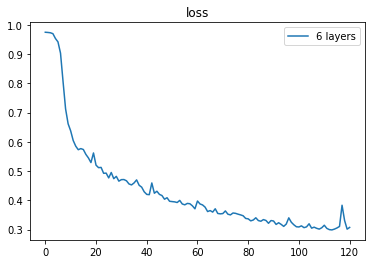

KeyError: ignored

In [13]:
for i,hist in enumerate(histories):
  plt.plot(hist.history['loss'],label="{} layers".format(depths[i]))
plt.legend()
plt.title('loss')
plt.show()
for i,hist in enumerate(histories):
  plt.plot(hist.history['mean_io_u_{}'.format(str(1+i))],label="{} layers".format(depths[i]))
plt.legend()
plt.title('mean_io_u score')
plt.show()

In [14]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve,precision_score,recall_score

#test data

In [15]:

# data
data_location = "/content/drive/My Drive/IDRid/A. Segmentation/1. Original Images/b. Testing Set"
test_data = []  # create an empty list
for (dirName, subdirList, fileList) in sorted(os.walk(data_location)):
    for fileName in sorted(fileList):
        if ".jpg" in fileName.lower() :
            test_data.append(os.path.join(dirName,fileName))
    
print(len(test_data))
target_root_location = "/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/"

test_data_gt = []  # create an empty list
segs=['1. Microaneurysms','2. Haemorrhages','3. Hard Exudates','4. Soft Exudates']
for seg in segs:
  data_location=target_root_location+seg
  print(data_location)
  seg_mask=[]
  for dirName, subdirList, fileList in sorted(os.walk(data_location)):
      for filename in sorted(fileList):
          if ".tif" in filename.lower() :
              seg_mask.append(os.path.join(dirName,filename))
              
  test_data_gt.append(seg_mask)
print(len(test_data_gt));

27
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/1. Microaneurysms
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/2. Haemorrhages
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/3. Hard Exudates
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/4. Soft Exudates
4


In [16]:
test_batch = np.zeros(shape = (len(test_data), 512,512, 3));
for file_index in range(0,len(test_data)):
    #print(file_index)
    # image
    test_batch[file_index, :, :,:] = resize(imread(test_data[int(file_index)]), (512,512))

# Normalize
test_batch  = test_batch/255
test_label = np.zeros(shape = (len(test_data_gt[1]), 512,512, 1));
# but i am filing the test_label serially ie if one mask is not there i am not leaving that place balnk but filing the next mask in its place
for file_index in range(0,len(test_data_gt[1])):  
  img = cv2.cvtColor(imread(test_data_gt[1][file_index]), cv2.COLOR_BGRA2BGR)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
  test_label[file_index, :, :,:] = np.expand_dims(resize(img, (512,512)), axis = 2)
# scale to 0-1
test_label[:,:,:,0]  = (test_label[:,:,:,0])/np.max(test_label)# - test_label[:,:,:,0].min(axis=0)) / (test_label[:,:,:,0].max(axis=0) - test_label[:,:,:,0].min(axis=0)+1e-10)
# binarize the masks
mask = test_label[:,:,:,:] > 0.25
test_label[mask] = 1
test_label[~mask] = 0

In [17]:
print(test_batch.shape)
print(test_label.shape)

(27, 512, 512, 3)
(27, 512, 512, 1)


6 layers
train  0  test roc 0.8880409727653644
Train  F1 score: 0.000000 Test F1 score: 0.517569
Accuracy: 0.991382
natural threshold train AUPR 0  test AUPR 0.47054853343866554


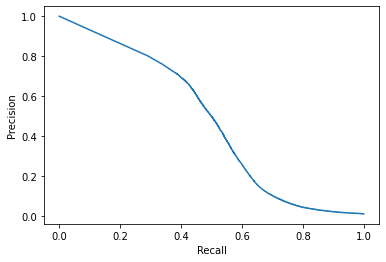

In [18]:
for j,model in enumerate(models):
  print(depths[j], "layers")
  predicted_test_label=np.zeros(test_label.shape)
  for i in range(27):
  #print(np.expand_dims(test_batch[i],axis=0).shape)
    predicted_test_label[i]=models[j].predict(np.expand_dims(test_batch[i],axis=0))
  #generate the masks
  
  # ROC
  test_auc = roc_auc_score(test_label.reshape(-1),predicted_test_label.reshape(-1))
  #train_auc = roc_auc_score(train_label.reshape(-1),predicted_train_label.reshape(-1))
  print("train ",0," test roc",test_auc)
  
  # F1
  testy, yhat_classes=(test_label.reshape(-1),np.round(predicted_test_label.reshape(-1)))
  test_f1 = f1_score(testy, yhat_classes)
  #testy, yhat_classes=train_label.reshape(-1),np.round(predicted_train_label.reshape(-1))
  #train_f1 = f1_score(testy, yhat_classes)
  train_f1=0
  print('Train  F1 score: %f' % train_f1,'Test F1 score: %f' % test_f1)

  
  #accuracy
  accuracy = accuracy_score(testy, yhat_classes)
  print('Accuracy: %f' % accuracy)
  #AUPR
  
  test_aupr = precision_recall_curve(test_label.reshape(-1),predicted_test_label.reshape(-1))
  train_auc=0
  test_auc=auc(test_aupr[1],test_aupr[0] )
  print("natural threshold train AUPR",train_auc," test AUPR",test_auc)
  
  #plot Precision recall curve
  plt.plot(test_aupr[1],test_aupr[0])
  plt.ylabel('Precision')
  plt.xlabel('Recall')
  plt.show()
  #del predicted_test_label 

(512, 512, 1)


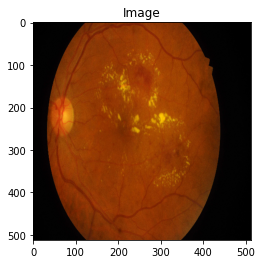

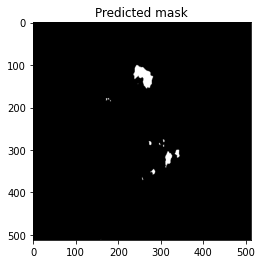

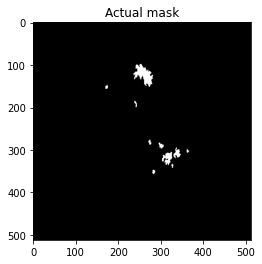

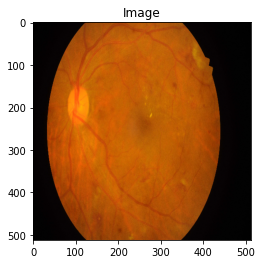

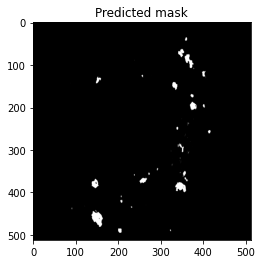

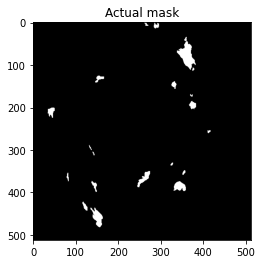

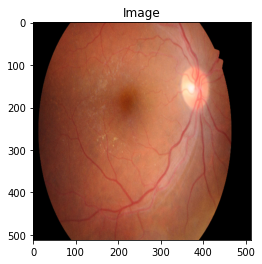

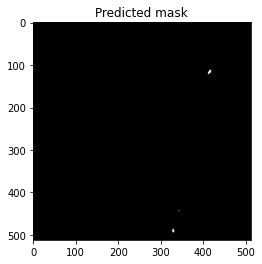

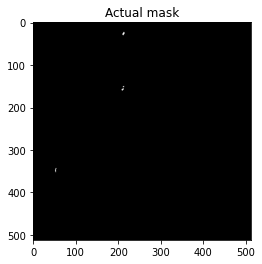

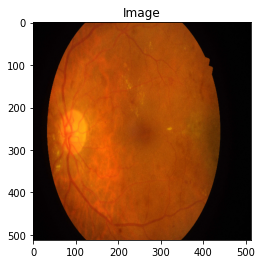

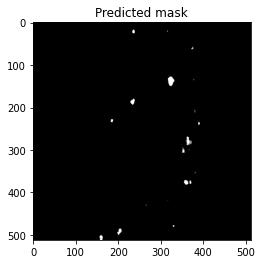

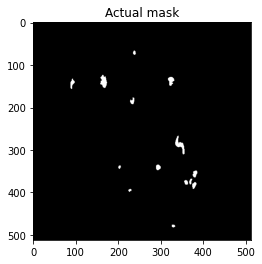

In [19]:
print(predicted_test_label[0].shape)
for i in range(4):
    plt.imshow(test_batch[i,:,:,:])
    plt.title("Image")
    plt.show()  
    plt.imshow(np.squeeze(predicted_test_label[i,:,:,:], axis = 2),cmap='gray')
    plt.title("Predicted mask")
    plt.show()
    plt.imshow(np.squeeze(test_label[i,:,:,:], axis = 2), cmap='gray')
    plt.title("Actual mask")
    plt.show()

#individaul test scores


In [21]:
def dice_score(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return dice

In [22]:

f1_scores=[]
aupr=[]
for i in range(27):
  # F1
  #testy, yhat_classes=(test_label[i].reshape(-1),np.round(predicted_test_label[i].reshape(-1)))
  #test_f1 = f1_score(testy, yhat_classes)
  testy, yhat_classes=(np.expand_dims(test_label[i],axis=0),np.expand_dims(predicted_test_label[i],axis=0))
  test_f1 = dice_score(testy, yhat_classes)
  

  train_f1=0
  print('Train  F1 score: %f' % train_f1,'Test F1 score: %f' % test_f1)
  f1_scores.append(test_f1)
  #AUPR
  
  test_aupr = precision_recall_curve(test_label[i].reshape(-1),predicted_test_label[i].reshape(-1))
  train_auc=0
  test_auc=auc(test_aupr[1],test_aupr[0] )
  print("natural threshold train AUPR",train_auc," test AUPR",test_auc)
  aupr.append(test_auc)

Train  F1 score: 0.000000 Test F1 score: 0.771844
natural threshold train AUPR 0  test AUPR 0.7745260818884283
Train  F1 score: 0.000000 Test F1 score: 0.544982
natural threshold train AUPR 0  test AUPR 0.4943328779222764
Train  F1 score: 0.000000 Test F1 score: 0.006500
natural threshold train AUPR 0  test AUPR 0.001433410964181462
Train  F1 score: 0.000000 Test F1 score: 0.325328
natural threshold train AUPR 0  test AUPR 0.2980177049708802
Train  F1 score: 0.000000 Test F1 score: 0.497560
natural threshold train AUPR 0  test AUPR 0.4892451092834193
Train  F1 score: 0.000000 Test F1 score: 0.525627
natural threshold train AUPR 0  test AUPR 0.4696887611249691
Train  F1 score: 0.000000 Test F1 score: 0.453987
natural threshold train AUPR 0  test AUPR 0.5881336375867879
Train  F1 score: 0.000000 Test F1 score: 0.466132
natural threshold train AUPR 0  test AUPR 0.3108497239555948
Train  F1 score: 0.000000 Test F1 score: 0.506254
natural threshold train AUPR 0  test AUPR 0.6724358778572763

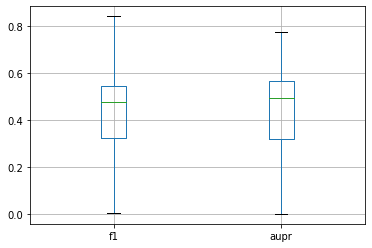

In [23]:
import pandas as pd
df = pd.DataFrame(np.array([f1_scores,aupr]).reshape(27,2), columns=['f1','aupr'])
df.plot.box(grid='True')